# Training a convolution neural network to classify handwritten numbers

Trains a simple convnet on the MNIST dataset.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical

/Users/wdeback/anaconda/envs/dl-tut/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

num_classes = 10

# to save time, we will only use the first 25% of the data
fraction = 0.10
cut = int(x_train.shape[0]*fraction)
x_train = x_train[:cut]
y_train = y_train[:cut]
cut = int(x_test.shape[0]*fraction)
x_test = x_test[:cut]
y_test = y_test[:cut]

# input image dimensions
img_rows, img_cols = x_train.shape[1:]
print('img_rows = {}, img_cols = {}'.format(img_rows, img_cols))


(60000, 28, 28)
(60000,)
img_rows = 28, img_cols = 28


Plot some samples from the image data set with titles showing the ground truth labels

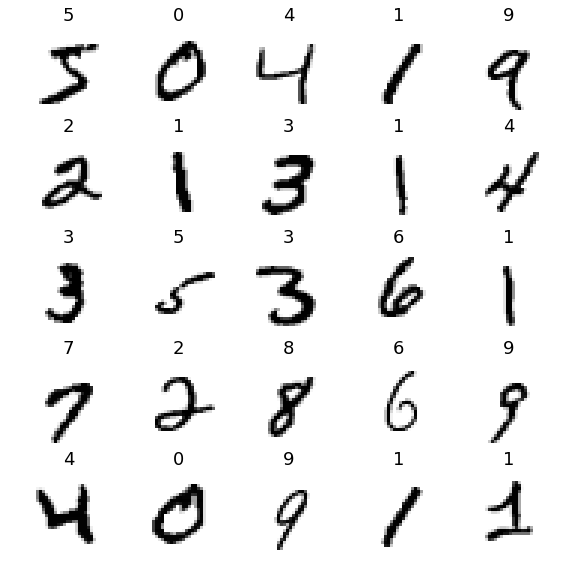

In [44]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('{}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})

plot_images(x_train[:25], y_train[:25])

We must be very careful about the format in which we should provide our data to the network.

If you use Tensorflow as a backend (as we are doing here), the image data should be provided in a format with the channels (e.g. RGB) as last dimension:

_NUM x WIDTH x HEIGHT x CHANNELS_ (NWHC)

If you use Theano as a backend, the dimensional ordering is NCWH (channels before).

Although we are dealing with grayscale image data and only have a single channel, we still need to add a dimension for the channels to obtain a 4D input tensor.


In [5]:
X_train = np.expand_dims(x_train, 3)
X_test = np.expand_dims(x_test, 3)
print('New shape: {}'.format(X_train.shape))

New shape: (6000, 28, 28, 1)


__Preprocessing__

We will convert from uint8 to float encoding and scale the values in our image to lie between 0 and 1.

In [6]:
X_train = X_train.astype('float32')
X_train = X_train.astype('float32')
X_train /= 255.
X_train /= 255.
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (6000, 28, 28)
6000 train samples
1000 test samples


__One-hot encoding__

We need to convert the labels using the one-hot encoding scheme

In [7]:
# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Define a convolutional neural network

In [28]:
def CNN(input_shape):
    from keras import models, layers
    
    i = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(i)
    x = layers.MaxPool2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.25)(x) 
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.25)(x) 
    
    o = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=[i], outputs=[o])
    

In [29]:
model = CNN(input_shape=X_train.shape[1:])

__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model, rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

# Train the neural network

In [34]:
batch_size = 128
epochs = 20

In [35]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test))


Train on 6000 samples, validate on 1000 samples
Epoch 1/20
4352/6000 [====================>.........] - ETA: 2s - loss: 0.6386 - acc: 0.7937 

KeyboardInterrupt: 

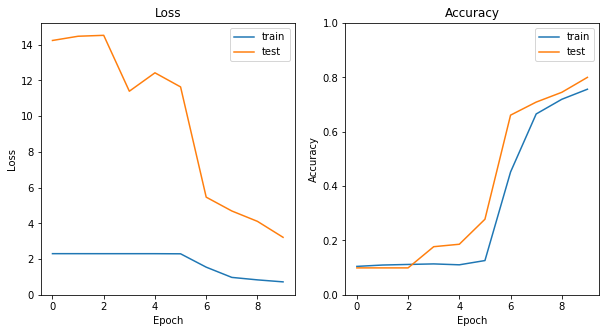

In [33]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

In [36]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1000/1000 [==============================] - 1s 586us/step
Test loss: 3.4815085983276366
Test accuracy: 0.784


# Predict unseen examples

In [51]:
num=36
indices = np.random.choice(len(X_test), size=num)
import time
start = time.time()
y_pred = model.predict(X_test[indices], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

36/36 [==============================] - 0s 566us/step
Exec time per prediction = 0.001


Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

To convert them back to class numbers (0-9), we want to get the index of the output neuron with the highest activation using `argmax`.

In [52]:
Y_pred = np.argmax(y_pred, axis=1)

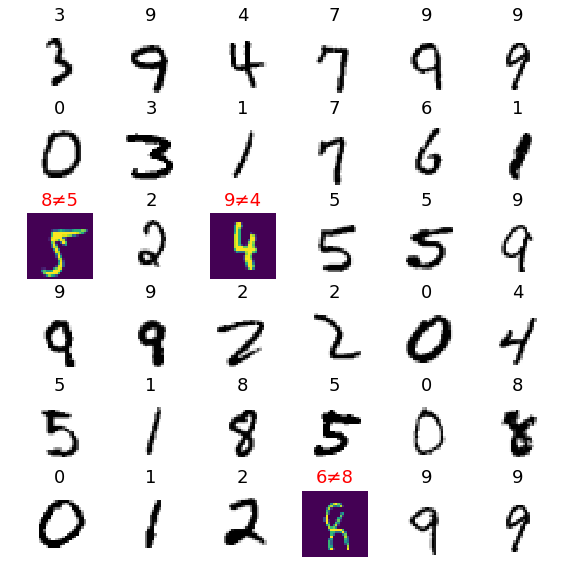

In [53]:
plot_images(X_test[indices], Y_pred, gt=y_test[indices])